## VIET NAM REGION SPEECH RECOGNITION

## 1. Import thư viện

In [1]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
# %matplotlib inline
import os
import csv
from tqdm import tqdm
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc

## 2. Tạo các cột và các feature

In [2]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff'
n_mfcc = 20
for i in range(1, n_mfcc + 1):
    header += f' mfcc{i}'
header += ' label'
header = header.split()
print(header)

['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']


## 3. Đọc dữ liệu & Trích xuất đặc trưng

In [3]:
# Định nghĩa các đường dẫn tới thư mục chứa dữ liệu âm thanh
path_1 = r"D:\HK7\DL\CK\data"

# Khởi tạo danh sách để lưu dữ liệu
data = []

for root, dirs, files in os.walk(path_1):  # Duyệt qua cả thư mục con
    for filename in files:
        if filename.endswith(".wav"):  # Kiểm tra định dạng .wav
            filepath = os.path.join(root, filename)  # Đường dẫn đầy đủ
            try:
                y, sr = librosa.load(filepath, mono=True, duration=10)
                chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
                rmse = librosa.feature.rms(y=y)
                spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
                spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
                rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

                # Tính giá trị trung bình của các đặc trưng
                features = {
                    "filename": filename,
                    "chroma_stft": np.mean(chroma_stft),
                    "rmse": np.mean(rmse),
                    "spectral_centroid": np.mean(spec_cent),
                    "spectral_bandwidth": np.mean(spec_bw),
                    "rolloff": np.mean(rolloff)
                }
                for i, mfcc_coef in enumerate(mfcc):
                    features[f"mfcc{i+1}"] = np.mean(mfcc_coef)

                # Phân loại nhãn dựa trên thư mục cha
                if "MienBac" in root:
                    features["label"] = "North"
                elif "MienNam" in root:
                    features["label"] = "Southern"
                elif "MienTrung" in root:
                    features["label"] = "Central"
                else:
                    features["label"] = "Unknow"

                # Thêm dữ liệu vào danh sách
                data.append(features)
            except Exception as e:
                print(f"Error processing {filepath}: {e}") 
# Tạo DataFrame từ danh sách dữ liệu
df = pd.DataFrame(data)
df


,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,MienBac_1.wav,0.433138,0.036451,1596.975548,1516.522148,3270.510742,-371.290405,119.095016,-38.221783,35.103962,...,1.068819,5.046175,-0.609991,6.432574,-0.487368,-0.582035,3.915698,-0.243485,-0.756806,North
1,MienBac_10.wav,0.456242,0.026085,1619.800736,1587.076466,3355.590820,-404.394073,119.792366,-35.312191,48.404232,...,2.103465,8.030417,-0.534514,8.144609,-0.800167,0.142757,5.049190,-1.184503,1.374450,North
2,MienBac_100.wav,0.355861,0.044271,1706.946191,1546.312109,3575.264223,-353.434814,105.985565,-44.659966,46.866547,...,4.998605,3.323756,1.647984,1.459667,-1.500765,1.392599,-0.100386,0.163216,4.243375,North
3,MienBac_1000.wav,0.425201,0.049841,1385.269990,1330.744069,2661.447976,-356.926331,136.628448,-38.203022,18.403654,...,-4.572938,-2.055456,-8.153857,0.243182,-4.126165,-5.676708,-3.412722,-4.713512,-8.632580,North
4,MienBac_1001.wav,0.416110,0.039230,1471.792072,1452.601195,3053.655305,-379.015869,117.311134,-30.436771,27.396723,...,-0.212975,2.620880,-7.519022,3.698057,-4.234212,-6.595409,-1.419156,-3.490474,-7.307481,North
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6292,MienTrung_995.wav,0.400215,0.064068,1645.450458,1533.616767,3127.259115,-356.959351,89.653465,-35.334438,16.407570,...,-6.867441,-3.872725,-3.115511,-3.334291,-8.557551,-3.437302,-3.644207,3.577759,4.610863,Central
6293,MienTrung_996.wav,0.335046,0.081106,1646.777195,1524.463477,3091.040039,-311.726074,90.723709,-38.851582,15.374019,...,-9.954857,-1.983296,-4.187320,-4.866129,-5.720509,-1.744524,0.665787,7.850665,7.492328,Central
6294,MienTrung_997.wav,0.368777,0.068087,1730.871091,1556.056334,3270.143522,-344.869446,81.285011,-43.622581,17.161789,...,-8.237623,-2.656732,-6.001698,-3.932270,-9.337467,-3.129993,-1.919762,5.879200,8.476551,Central
6295,MienTrung_998.wav,0.356777,0.061204,1433.605038,1523.648019,2844.036812,-376.766907,105.694229,-11.729777,13.755819,...,-9.475019,-2.950612,-3.770097,-4.030691,-6.891387,-4.641849,-1.013492,3.337575,4.866607,Central


In [4]:
os.listdir(path_1)

['MienBac', 'MienNam', 'MienTrung']

In [5]:
df.to_csv("data.csv", index = False)

## 4. Encoding và Xử lý data imbalance

In [6]:
df = pd.read_csv("data.csv")
df

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,MienBac_1.wav,0.433138,0.036451,1596.975548,1516.522148,3270.510742,-371.29040,119.095020,-38.221783,35.103962,...,1.068819,5.046175,-0.609991,6.432574,-0.487368,-0.582035,3.915698,-0.243485,-0.756806,North
1,MienBac_10.wav,0.456242,0.026085,1619.800736,1587.076466,3355.590820,-404.39407,119.792366,-35.312190,48.404232,...,2.103465,8.030417,-0.534514,8.144609,-0.800167,0.142757,5.049190,-1.184503,1.374450,North
2,MienBac_100.wav,0.355861,0.044271,1706.946191,1546.312109,3575.264223,-353.43480,105.985565,-44.659966,46.866547,...,4.998605,3.323756,1.647984,1.459667,-1.500765,1.392599,-0.100386,0.163216,4.243375,North
3,MienBac_1000.wav,0.425201,0.049841,1385.269990,1330.744069,2661.447976,-356.92633,136.628450,-38.203022,18.403654,...,-4.572938,-2.055456,-8.153857,0.243182,-4.126165,-5.676708,-3.412722,-4.713512,-8.632580,North
4,MienBac_1001.wav,0.416110,0.039230,1471.792072,1452.601195,3053.655305,-379.01587,117.311134,-30.436771,27.396723,...,-0.212975,2.620880,-7.519023,3.698057,-4.234212,-6.595409,-1.419156,-3.490473,-7.307481,North
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6292,MienTrung_995.wav,0.400215,0.064068,1645.450458,1533.616767,3127.259115,-356.95935,89.653465,-35.334440,16.407570,...,-6.867441,-3.872725,-3.115511,-3.334291,-8.557551,-3.437302,-3.644207,3.577759,4.610863,Central
6293,MienTrung_996.wav,0.335046,0.081106,1646.777195,1524.463477,3091.040039,-311.72607,90.723710,-38.851580,15.374019,...,-9.954857,-1.983296,-4.187320,-4.866129,-5.720509,-1.744524,0.665787,7.850665,7.492328,Central
6294,MienTrung_997.wav,0.368777,0.068087,1730.871091,1556.056334,3270.143522,-344.86945,81.285010,-43.622580,17.161789,...,-8.237623,-2.656732,-6.001698,-3.932270,-9.337467,-3.129993,-1.919762,5.879200,8.476551,Central
6295,MienTrung_998.wav,0.356777,0.061204,1433.605038,1523.648019,2844.036812,-376.76690,105.694230,-11.729777,13.755819,...,-9.475019,-2.950612,-3.770097,-4.030691,-6.891387,-4.641849,-1.013492,3.337575,4.866607,Central


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6297 entries, 0 to 6296
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   filename            6297 non-null   object 
 1   chroma_stft         6297 non-null   float64
 2   rmse                6297 non-null   float64
 3   spectral_centroid   6297 non-null   float64
 4   spectral_bandwidth  6297 non-null   float64
 5   rolloff             6297 non-null   float64
 6   mfcc1               6297 non-null   float64
 7   mfcc2               6297 non-null   float64
 8   mfcc3               6297 non-null   float64
 9   mfcc4               6297 non-null   float64
 10  mfcc5               6297 non-null   float64
 11  mfcc6               6297 non-null   float64
 12  mfcc7               6297 non-null   float64
 13  mfcc8               6297 non-null   float64
 14  mfcc9               6297 non-null   float64
 15  mfcc10              6297 non-null   float64
 16  mfcc11

In [8]:
df['label']=df['label'].replace(['North'],1)
df['label']=df['label'].replace(['Southern'],2)
df['label']=df['label'].replace(['Central'],3)


In [9]:
df

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,MienBac_1.wav,0.433138,0.036451,1596.975548,1516.522148,3270.510742,-371.29040,119.095020,-38.221783,35.103962,...,1.068819,5.046175,-0.609991,6.432574,-0.487368,-0.582035,3.915698,-0.243485,-0.756806,1
1,MienBac_10.wav,0.456242,0.026085,1619.800736,1587.076466,3355.590820,-404.39407,119.792366,-35.312190,48.404232,...,2.103465,8.030417,-0.534514,8.144609,-0.800167,0.142757,5.049190,-1.184503,1.374450,1
2,MienBac_100.wav,0.355861,0.044271,1706.946191,1546.312109,3575.264223,-353.43480,105.985565,-44.659966,46.866547,...,4.998605,3.323756,1.647984,1.459667,-1.500765,1.392599,-0.100386,0.163216,4.243375,1
3,MienBac_1000.wav,0.425201,0.049841,1385.269990,1330.744069,2661.447976,-356.92633,136.628450,-38.203022,18.403654,...,-4.572938,-2.055456,-8.153857,0.243182,-4.126165,-5.676708,-3.412722,-4.713512,-8.632580,1
4,MienBac_1001.wav,0.416110,0.039230,1471.792072,1452.601195,3053.655305,-379.01587,117.311134,-30.436771,27.396723,...,-0.212975,2.620880,-7.519023,3.698057,-4.234212,-6.595409,-1.419156,-3.490473,-7.307481,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6292,MienTrung_995.wav,0.400215,0.064068,1645.450458,1533.616767,3127.259115,-356.95935,89.653465,-35.334440,16.407570,...,-6.867441,-3.872725,-3.115511,-3.334291,-8.557551,-3.437302,-3.644207,3.577759,4.610863,3
6293,MienTrung_996.wav,0.335046,0.081106,1646.777195,1524.463477,3091.040039,-311.72607,90.723710,-38.851580,15.374019,...,-9.954857,-1.983296,-4.187320,-4.866129,-5.720509,-1.744524,0.665787,7.850665,7.492328,3
6294,MienTrung_997.wav,0.368777,0.068087,1730.871091,1556.056334,3270.143522,-344.86945,81.285010,-43.622580,17.161789,...,-8.237623,-2.656732,-6.001698,-3.932270,-9.337467,-3.129993,-1.919762,5.879200,8.476551,3
6295,MienTrung_998.wav,0.356777,0.061204,1433.605038,1523.648019,2844.036812,-376.76690,105.694230,-11.729777,13.755819,...,-9.475019,-2.950612,-3.770097,-4.030691,-6.891387,-4.641849,-1.013492,3.337575,4.866607,3


In [10]:
df['label'].value_counts()

2    3000
1    2147
3    1150
Name: label, dtype: int64

In [11]:
# Under-sampling
min_count = df['label'].value_counts().min()
df_balance = df.groupby('label').sample(n=min_count, random_state=42)
print(df_balance['label'].value_counts())

1    1150
2    1150
3    1150
Name: label, dtype: int64


<AxesSubplot:>

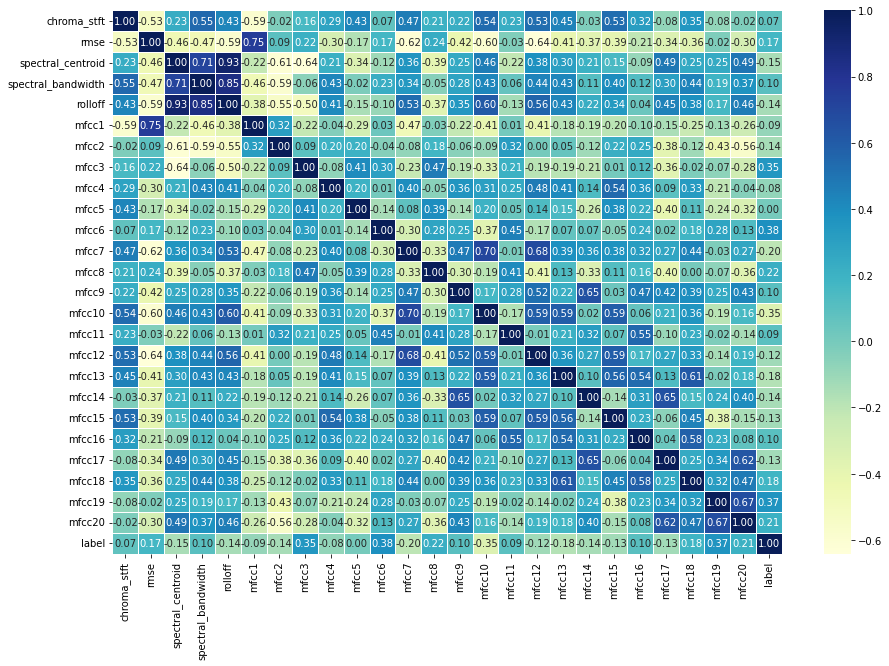

In [12]:
# Loại bỏ cột "filename" khỏi DataFrame trước khi tính toán ma trận tương quan
df_numeric = df_balance.drop(columns=["filename"])

# Tính toán ma trận tương quan cho các cột số
corr_matrix = df_numeric.corr()

# Hiển thị biểu đồ heatmap
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix,
           annot=True,
           linewidths=0.5,
           fmt=".2f",
           cmap="YlGnBu")

In [13]:
data = df_balance.copy()
data

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
1159,MienBac_2041.wav,0.353934,0.078496,1291.323752,1369.340398,2521.952186,-288.94458,132.369860,-15.968634,43.578983,...,-4.818188,1.916174,2.308416,1.491263,0.947408,1.848741,0.227600,-0.959824,-0.195943,1
2016,MienBac_881.wav,0.482593,0.025129,1425.106606,1548.005942,3093.131296,-476.08795,102.275400,-5.485220,8.211903,...,-0.097711,-2.393570,-5.615120,-3.099507,-3.999441,-5.350213,-3.121013,-3.834807,-6.280816,1
978,MienBac_188.wav,0.447098,0.032451,1784.875752,1800.123278,3954.555388,-420.16315,78.597626,-12.958810,39.933064,...,7.153065,5.992833,5.525724,8.816318,-0.582076,4.690666,4.623351,3.389696,2.066276,1
759,MienBac_1682.wav,0.299804,0.102118,1543.389640,1497.104187,3115.016287,-243.66590,121.066590,-43.694744,41.850760,...,-4.748557,8.238137,-4.457415,0.825346,-2.600186,3.405865,-0.623065,-1.541871,1.129510,1
874,MienBac_1786.wav,0.329795,0.070449,1442.794637,1363.971210,2620.981019,-268.93246,134.588710,-45.130585,20.866163,...,-4.742492,5.269853,-1.378154,-1.755146,-3.014821,2.432252,-0.556684,0.874259,-1.065736,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5998,MienTrung_73.wav,0.418047,0.050383,1476.030892,1539.224478,3217.251205,-348.66763,128.339400,-24.978600,45.242207,...,2.340204,-0.260639,-2.793352,5.446135,-2.959678,-2.706635,0.049900,-2.602421,1.462181,3
5580,MienTrung_353.wav,0.354786,0.049931,1341.123287,1460.651315,2788.213348,-391.86813,98.746340,-9.053617,21.960842,...,-2.119120,-6.585354,-2.228422,-6.003097,-11.581080,-0.996031,-5.783717,-1.019956,2.126106,3
5497,MienTrung_279.wav,0.383998,0.055667,1544.946442,1551.853562,3157.023926,-384.12497,87.132740,-14.547893,22.314096,...,-0.688253,0.540292,-3.902543,-4.273774,-8.099354,-2.652989,-3.922998,0.386043,2.110037,3
5308,MienTrung_1143.wav,0.350763,0.082188,1539.915840,1437.575785,2858.630003,-328.05032,93.920630,-38.992170,13.667394,...,-8.688128,-2.221478,-6.823264,-2.967955,-7.219628,-4.328331,-2.910221,2.582143,4.707764,3


In [14]:
X = data.iloc[:,  6:-1]
y = data.loc[:,'label']

In [15]:
X

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
1159,-288.94458,132.369860,-15.968634,43.578983,-12.046405,0.610827,1.444595,-5.507260,2.762674,-3.479532,-1.951324,-4.818188,1.916174,2.308416,1.491263,0.947408,1.848741,0.227600,-0.959824,-0.195943
2016,-476.08795,102.275400,-5.485220,8.211903,-6.142055,-5.663055,12.531361,-2.017577,-4.553106,6.452496,2.441478,-0.097711,-2.393570,-5.615120,-3.099507,-3.999441,-5.350213,-3.121013,-3.834807,-6.280816
978,-420.16315,78.597626,-12.958810,39.933064,-7.878526,4.670471,15.406467,-10.974846,3.568075,10.736917,-0.799957,7.153065,5.992833,5.525724,8.816318,-0.582076,4.690666,4.623351,3.389696,2.066276
759,-243.66590,121.066590,-43.694744,41.850760,-29.250761,4.940102,-3.862505,-13.278567,-3.341638,1.357639,-3.896906,-4.748557,8.238137,-4.457415,0.825346,-2.600186,3.405865,-0.623065,-1.541871,1.129510
874,-268.93246,134.588710,-45.130585,20.866163,-32.084724,-2.954888,-6.167369,-5.928683,-7.264371,-1.313947,3.151436,-4.742492,5.269853,-1.378154,-1.755146,-3.014821,2.432252,-0.556684,0.874259,-1.065736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5998,-348.66763,128.339400,-24.978600,45.242207,-10.564146,0.833743,5.089394,-12.233516,-1.415671,1.450817,1.216244,2.340204,-0.260639,-2.793352,5.446135,-2.959678,-2.706635,0.049900,-2.602421,1.462181
5580,-391.86813,98.746340,-9.053617,21.960842,-12.227278,-1.686989,2.008627,-10.266789,-4.732474,-3.776518,-4.012753,-2.119120,-6.585354,-2.228422,-6.003097,-11.581080,-0.996031,-5.783717,-1.019956,2.126106
5497,-384.12497,87.132740,-14.547893,22.314096,-16.485233,2.462357,4.767589,-10.409103,-1.919266,0.986166,-5.517184,-0.688253,0.540292,-3.902543,-4.273774,-8.099354,-2.652989,-3.922998,0.386043,2.110037
5308,-328.05032,93.920630,-38.992170,13.667394,-18.408316,-0.562674,-7.907431,-4.606317,-4.275772,-5.337899,-6.451184,-8.688128,-2.221478,-6.823264,-2.967955,-7.219628,-4.328331,-2.910221,2.582143,4.707764


In [16]:
y

1159    1
2016    1
978     1
759     1
874     1
       ..
5998    3
5580    3
5497    3
5308    3
5251    3
Name: label, Length: 3450, dtype: int64

## 5. Chia dữ liệu Train/Test

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=2)

In [18]:
X_train

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
2501,-281.13132,132.620760,-30.473118,10.599955,-10.107575,-5.920490,-11.048656,4.028037,1.949790,-0.393817,-1.524587,-5.763119,3.037755,-19.288757,-1.196675,0.017570,-17.486818,-4.988773,-7.346647,-5.120961
2525,-302.50280,131.757680,-25.940903,21.546532,-4.548015,-7.372928,-2.554568,1.487105,-14.334281,-3.402359,1.831302,-4.360352,-0.797182,-13.165237,-0.247404,-10.366684,-11.901826,-4.113494,-9.834103,-0.434534
3538,-431.40717,92.934540,-7.255927,13.033488,-10.410532,2.738406,-3.896252,-2.259535,-8.198576,0.607020,-0.954988,-1.995889,-4.009703,-3.872270,0.913830,-10.191881,0.967102,-3.947629,-1.688744,0.407262
3419,-254.29580,123.766090,-45.078922,30.689980,-33.421440,-6.316786,-14.295242,-12.652984,-7.875256,-8.912065,-2.177145,-6.911776,-3.579814,-4.335665,-2.293052,-9.222555,-1.368087,-3.534893,-6.897344,-4.826675
126,-442.12555,117.782330,-25.622433,18.676222,-2.986222,-6.630010,11.486465,-2.237710,-13.199121,4.492633,-2.281816,-4.593164,-1.110923,-7.789472,2.159907,-3.564526,-7.628788,-1.780913,-1.729740,-4.643321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5979,-314.11646,129.020870,12.263636,33.462704,-10.562336,2.815721,-12.022112,3.195004,-5.664591,-11.988071,-2.569477,-7.807738,-2.601870,-7.317465,-3.379716,-3.863075,-6.727365,-5.849608,-0.114171,-8.599039
3498,-365.57635,87.185524,-15.473131,12.576673,-15.358652,2.465940,-4.890192,1.181922,-11.085659,-1.045781,-4.774357,-4.179936,-1.561653,-6.326606,1.597871,-10.901318,-0.503315,-5.991489,-4.873581,-2.975757
5616,-334.45657,101.097930,-34.503410,28.015005,-21.242040,-9.651478,-2.657536,-10.227881,-5.302276,-4.045047,-12.275585,-8.133045,-4.200273,-5.602361,-8.185363,-10.484765,-0.489787,-5.272882,3.948622,7.059356
5300,-321.24420,100.773430,-36.429657,9.900050,-27.189877,6.243701,-7.870013,-2.615643,-4.664206,-0.803450,-5.583198,-8.889705,-2.727981,-9.007340,-2.908105,-7.514004,-1.411069,-3.020867,7.089968,6.123827


In [19]:
y_train.value_counts()

1    928
3    917
2    915
Name: label, dtype: int64

In [20]:
from tensorflow.keras.utils import to_categorical
# Chuẩn bị dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Chuyển đổi y_train, y_test thành one-hot encoding
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

In [21]:
X_train_scaled

array([[ 1.34409528,  0.83944702, -0.24223715, ..., -0.6819566 ,
        -1.60551978, -0.86730303],
       [ 0.8682192 ,  0.79325956,  0.0055439 , ..., -0.47627651,
        -2.20974305,  0.02488589],
       [-2.00207831, -1.28434862,  1.02707161, ..., -0.43730023,
        -0.23116899,  0.18514468],
       ...,
       [ 0.1567086 , -0.84748736, -0.46257754, ..., -0.7487186 ,
         1.13819338,  1.451552  ],
       [ 0.45090679, -0.86485287, -0.56788753, ..., -0.21952224,
         1.90125175,  1.27344858],
       [-0.19063373, -0.69688847,  0.09519818, ..., -0.30133801,
        -0.79306722,  0.17601377]])

In [22]:
y_train_onehot 

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

## 6. Train Model deep


In [23]:
model_acc=[]

In [24]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import f1_score
import tensorflow as tf 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [25]:


# MLP Model
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y_train_onehot.shape[1], activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Huấn luyện MLP
mlp_model.fit(X_train_scaled, y_train_onehot, epochs=10, batch_size=32, verbose=0)

# Đánh giá MLP
mlp_train_acc = mlp_model.evaluate(X_train_scaled, y_train_onehot, verbose=0)[1]
mlp_test_acc = mlp_model.evaluate(X_test_scaled, y_test_onehot, verbose=0)[1]
y_pred_mlp = tf.argmax(mlp_model.predict(X_test_scaled), axis=1).numpy()
mlp_f1 = f1_score(y_test, y_pred_mlp, average='macro')

m = 'MLP'
print("Model:", m)
print("Train Accuracy:", mlp_train_acc)
print("Test Accuracy:", mlp_test_acc)
print("F1 Score:", mlp_f1)
model_acc.append([m, mlp_train_acc, mlp_test_acc, mlp_f1])

d:\PYTHON\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Model: MLP
Train Accuracy: 0.949999988079071
Test Accuracy: 0.9376811385154724
F1 Score: 0.9372440437199091


In [ ]:
# CNN Model
cnn_model = Sequential([
    Conv2D(32, (1, 1), activation='relu', input_shape=(X_train_scaled.shape[1], 1, 1)),
    MaxPooling2D((2, 1)),  # Giảm chiều cao, giữ nguyên chiều rộng
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train_onehot.shape[1], activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Reshape dữ liệu cho CNN
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1, 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1, 1)
# Huấn luyện CNN
cnn_model.fit(X_train_cnn, y_train_onehot, epochs=10, batch_size=32, verbose=0)
# Đánh giá CNN
cnn_train_acc = cnn_model.evaluate(X_train_cnn, y_train_onehot, verbose=0)[1]
cnn_test_acc = cnn_model.evaluate(X_test_cnn, y_test_onehot, verbose=0)[1]
y_pred_cnn = tf.argmax(cnn_model.predict(X_test_cnn), axis=1).numpy()
cnn_f1 = f1_score(y_test, y_pred_cnn, average='macro')
m = 'CNN'
print("Model:", m)
print("Train Accuracy:", cnn_train_acc)
print("Test Accuracy:", cnn_test_acc)
print("F1 Score:", cnn_f1)
model_acc.append([m, cnn_train_acc, cnn_test_acc, cnn_f1])


d:\PYTHON\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#LSTM Model

# Chuyển đổi dữ liệu đầu vào thành dạng 3D cho LSTM (samples, timesteps, features)
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
# Xây dựng mô hình LSTM
model = Sequential()
# LSTM layer
model.add(LSTM(units=128, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=False))
# Dropout để tránh overfitting
model.add(Dropout(0.2))
# Lớp Dense đầu ra
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=y_train_onehot.shape[1], activation='softmax'))  # Số lớp output = số lớp phân loại
# Biên dịch mô hình
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Huấn luyện mô hình
history = model.fit(X_train_scaled, y_train_onehot, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test_onehot))
# Đánh giá mô hình
train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]
# Tính F1 score
y_pred = np.argmax(model.predict(X_test_scaled), axis=-1)
y_true = np.argmax(y_test_onehot, axis=-1)
f1 = f1_score(y_true, y_pred, average='weighted')
# In kết quả
m = 'LSTM'
print("Model:", m)
print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)
print("F1 Score:", f1)
# Lưu các kết quả vào danh sách
model_acc.append([m, train_acc, test_acc, f1])



Epoch 1/10


d:\PYTHON\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6129 - loss: 1.1558 - val_accuracy: 0.8145 - val_loss: 0.5221
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8743 - loss: 0.4085 - val_accuracy: 0.9043 - val_loss: 0.2727
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9213 - loss: 0.2404 - val_accuracy: 0.9420 - val_loss: 0.1798
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9424 - loss: 0.1688 - val_accuracy: 0.9609 - val_loss: 0.1405
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9576 - loss: 0.1380 - val_accuracy: 0.9565 - val_loss: 0.1301
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9615 - loss: 0.1170 - val_accuracy: 0.9652 - val_loss: 0.1077
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9655 - loss: 0.1010 - val_accuracy: 0.9623 - val_loss: 0.1126
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9672 - loss: 0.0922 - val_accuracy: 0.9609 - val_loss: 0.1024
Ep

In [ ]:
# Lưu mô hình
model.save(r'D:\HK7\DL\CK\NguyenTruongAn_TruongThanhThao_DL\model_LSTM.keras')


## 7. Đánh giá

In [ ]:
result = pd.DataFrame(model_acc, columns=['Model', 'Train_Acc','Test_Acc', 'F1 score'])

In [ ]:
result

,Model,Train_Acc,Test_Acc,F1 score
0,MLP,0.959058,0.953623,0.953467
1,CNN,0.912681,0.895652,0.895202
2,LSTM,0.972101,0.972464,0.972427


# apply

In [ ]:
# import sounddevice as sd
# from scipy.io.wavfile import write

# def record_audio(output_file, duration=5, sampling_rate=44100):
#     """
#     Ghi âm trực tiếp từ micro và lưu vào file WAV.
#     - output_file: Tên file WAV lưu.
#     - duration: Thời gian ghi âm (giây).
#     - sampling_rate: Tần số mẫu (Hz).
#     """
#     print("Bắt đầu ghi âm... Nói đi nào!")
#     audio_data = sd.rec(int(duration * sampling_rate), samplerate=sampling_rate, channels=1, dtype='int16')
#     sd.wait()  # Đợi ghi âm xong
#     write(output_file, sampling_rate, audio_data)  # Lưu file WAV
#     print(f"Ghi âm xong! File được lưu tại: {output_file}")

# # Gọi hàm để ghi âm
# record_audio(r"D:\HK7\DL\CK\data_test\giong_noi.wav", duration=5)  # Ghi âm 5 giây


In [ ]:
import librosa
import IPython.display as ipd

def play_audio_from_file(file_path):
    """
    Đọc và phát âm thanh từ đường dẫn file WAV.
    - file_path: Đường dẫn tới file âm thanh.
    """
    # Đọc file âm thanh
    audio_array, sampling_rate = librosa.load(file_path, sr=None)  # Giữ nguyên tần số mẫu ban đầu
    print(f"File Path: {file_path}")
    print(f"Sampling Rate: {sampling_rate} Hz")
    
    # Phát âm thanh
    ipd.display(ipd.Audio(audio_array, rate=sampling_rate))  # Hiển thị trình phát âm thanh
file_path =r"D:\HK7\DL\CK\data_test\giong_noi.wav"  # Đường dẫn tới file WAV
play_audio_from_file(file_path)



File Path: D:\HK7\DL\CK\data_test\giong_noi.wav
Sampling Rate: 44100 Hz


In [ ]:
import librosa
import numpy as np

# Hàm tiền xử lý file âm thanh
def preprocess_audio(file_path, scaler):
    """
    Tiền xử lý âm thanh:
    - Load âm thanh.
    - Trích xuất đặc trưng MFCC.
    - Chuẩn hóa đặc trưng.
    - Reshape để phù hợp với mô hình LSTM.
    """
    y, sr = librosa.load(file_path, sr=None, duration=10)  # Load âm thanh (10 giây)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)  # Trích xuất MFCC (20 coefficients)
    mfcc_mean = np.mean(mfcc.T, axis=0)  # Lấy trung bình của MFCC
    scaled_mfcc = scaler.transform([mfcc_mean])  # Chuẩn hóa đặc trưng
    # Thêm chiều thứ hai để phù hợp với LSTM
    scaled_mfcc = scaled_mfcc.reshape(scaled_mfcc.shape[0], 1, scaled_mfcc.shape[1])
    return scaled_mfcc
# Hàm dự đoán miền
def predict_region(file_path, model, scaler, label_mapping):
    """
    Dự đoán miền của giọng nói từ file âm thanh:
    - `file_path`: Đường dẫn tới file âm thanh.
    - `model`: Mô hình LSTM đã huấn luyện.
    - `scaler`: Bộ chuẩn hóa đã sử dụng trong quá trình huấn luyện.
    - `label_mapping`: Mapping từ nhãn số sang tên miền.
    """
    # Tiền xử lý file âm thanh
    processed_audio = preprocess_audio(file_path, scaler)
    # Dự đoán
    prediction = model.predict(processed_audio)
    predicted_label = np.argmax(prediction, axis=1)[0]  # Lấy nhãn dự đoán
    region = label_mapping.get(predicted_label, "Unknown")  # Chuyển nhãn sang tên miền
    return region

# Mapping nhãn sang tên miền
label_mapping = {
    1: "Miền Bắc",
    2: "Miền Trung",
    3: "Miền Nam"
}

# Ví dụ sử dụng
file_path =r"D:\HK7\DL\CK\data_test\giong_noi.wav" # Đường dẫn tới file âm thanh
predicted_region = predict_region(file_path, model, scaler, label_mapping)
print(f"Giọng nói này thuộc miền: {predicted_region}")


Shape of processed_audio: (1, 1, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Giọng nói này thuộc miền: Miền Bắc


d:\PYTHON\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# from tensorflow.keras.models import load_model

# loaded_mlp_model = load_model(r'D:\HK7\DL\CK\NguyenTruongAn_TruongThanhThao_DL\model_LSTM.keras')


In [ ]:
# file_path =r"D:\HK7\DL\CK\data_test\giong_noi.wav" 
# predicted_region = predict_region(file_path, loaded_mlp_model, scaler, label_mapping)

# print(f"Giọng nói này thuộc miền: {predicted_region}")

d:\PYTHON\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Shape of processed_audio: (1, 1, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
Giọng nói này thuộc miền: Miền Bắc
